In [3]:
import os
import torch, torch.utils, torch.utils.data
import torchvision
import torch.backends.cudnn as cudnn
import config, datasets,dataloaders, trainer, model_manager, inference, metric

import importlib
# importlib.reload(config)

cudnn.benchmark = True

In [4]:
# Initialize the configuration
conf = config.Config(
    num_classes=10,  # CIFAR10 classes
    train_ratio=0.8,
    val_ratio=0.2,
    num_epochs=20,
    lr=0.01,
    batch_size=64,
    num_workers=4,
    device=torch.device("cuda:0"),
    momentum=0.0001,
    weight_decay=0.0001,
    train_dir="data/train/",
    test_dir="data/test/",
    log_dir="./log/",
    checkpoint_dir="./log/checkpoint/",
    metric_file_path="./log/metric_results.json",
)
os.makedirs(conf.checkpoint_dir, exist_ok=True)

In [5]:
# Define the data transformation pipeline for the training set
train_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.RandAugment(),
        torchvision.transforms.ToTensor(),
        # https://github.com/facebookarchive/fb.resnet.torch/issues/180
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)
# Define the data transformation pipeline for the test set
test_transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        # https://github.com/facebookarchive/fb.resnet.torch/issues/180
        torchvision.transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616]),
    ]
)

In [6]:
# Initialize a custom dataset instance for CIFAR10 with specific transformations for training and testing
ds = datasets.CustomDatasets(
    standard_dataset_name="CIFAR10",
    train_transform=train_transform,
    test_transform=test_transform,
)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Create a custom dataset loader with the specified batch size and number of worker processes
dl = dataloaders.CustomDatasetLoader(batch_size=conf.batch_size, num_workers=conf.num_workers)
# Split the labeled dataset into training and validation sets based on the specified ratios
ds.split_labeled_dataset(train_ratio=conf.train_ratio, val_ratio=conf.val_ratio, enable_test_split=False)
# Set the test transformation for the validation dataset
ds.set_transform(ds.split_val_dataset, ds.test_transform)

Split train_datasets => split_train_dataset and split_val_dataset
ratio train : val = 0.8 : 0.2


In [8]:
# Print the transformations set for the training, validation, and test datasets
ds.print_set_transform(ds.split_train_dataset, "train")
ds.print_set_transform(ds.split_val_dataset, "val")
ds.print_set_transform(ds.labeled_test_dataset, "test")

train is set : Compose(
    RandAugment(num_ops=2, magnitude=9, num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)
val is set : Compose(
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)
test is set : Compose(
    ToTensor()
    Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.2435, 0.2616])
)


In [9]:
# Build data loaders for the labeled training, validation, and test datasets
dl.build_dataloaders(
    labeled_train_dataset=ds.split_train_dataset,
    labeled_val_dataset=ds.split_val_dataset,
    labeled_test_dataset=ds.labeled_test_dataset,
    unlabeled_test_dataset=None,
)

In [10]:
# Initialize a ResNet50 model without pre-trained weights
model = torchvision.models.resnet50(weights=None)
# Replace the fully connected layer with a new one matching the number of classes in the dataset
model.fc = torch.nn.Linear(in_features=model.fc.in_features, out_features=conf.num_classes)
# Initialize the loss function as CrossEntropyLoss without class weights
loss_fn = torch.nn.CrossEntropyLoss(weight=None)
# Initialize the optimizer as Stochastic Gradient Descent with specified learning rate, momentum, and weight decay
optimizer = torch.optim.SGD(
    params=model.parameters(), lr=conf.lr, momentum=conf.momentum, weight_decay=conf.weight_decay
)
# Calculate the total number of iterations for the learning rate scheduler
n_iterations = len(dl.labeled_train_loader) * conf.num_epochs
# Initialize the learning rate scheduler as CosineAnnealingLR with the total number of iterations
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_iterations)
# Initialize a ModelManager instance to handle the training, evaluation, and saving of the model
mm = model_manager.ModelManager(
    model=model, device=conf.device, loss_fn=loss_fn, optimizer=optimizer, lr_scheduler=lr_scheduler
)

In [11]:
# Initialize an ImageClassificationTrainer instance for managing the training process
trainer = trainer.ImageClassificationTrainer(
    model_manager=mm,
    train_loader=dl.labeled_train_loader,
    val_loader=dl.labeled_val_loader,
    total_epochs=conf.num_epochs,
    log_dir=conf.log_dir,
    checkpoint_dir=conf.checkpoint_dir,
)

In [12]:
# Start the training process
trainer.train()

100%|██████████| 20/20 [03:15<00:00,  9.79s/it]


In [13]:
# Reload the inference module (useful if there have been changes during runtime)
#importlib.reload(inference)

# Load the trained model weights from the checkpoint file
loaded_weights = torch.load(conf.checkpoint_dir + "model_20.pth")
mm.model.load_state_dict(loaded_weights)
test = inference.ImageClassifierInference(
    model_manager=mm,
    test_loader=dl.labeled_test_loader,
    num_classes=conf.num_classes,
    metric_file_path=conf.metric_file_path,
)
# Perform inference on the test dataset and obtain predictions
test.predict(is_classes=True)

  0%|          | 0/157 [00:00<?, ?it/s]/home/developer/.local/lib/python3.10/site-packages/torcheval/metrics/functional/classification/accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343967769/work/aten/src/ATen/native/TensorAdvancedIndexing.cpp:224.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")
100%|██████████| 157/157 [00:01<00:00, 132.64it/s]


<Axes: >

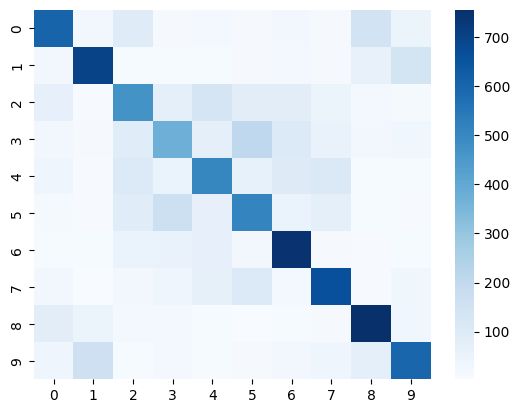

In [14]:
import json
import seaborn as sns

# Load the computed metrics from the specified file
with open(conf.metric_file_path) as f:
    metric = json.loads(f.read())
# Create a heatmap of the confusion matrix using seaborn
sns.heatmap(metric["ConfusionMatrix"], cmap="Blues")

In [15]:
import pandas as pd

# Create a DataFrame from the metric data and display it
df = pd.DataFrame(data=metric,index=ds.labeled_train_dataset.classes)
df

,Accuracy,Precision,Recall,F1,AUROC,AUPRC,Accuracy_per_class,Precision_per_class,Recall_per_class,F1_per_class,AUROC_per_class,AUPRC_per_class,ConfusionMatrix
airplane,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.604,0.645299,0.604,0.623967,0.937037,0.699707,"[604.0, 27.0, 95.0, 14.0, 20.0, 13.0, 24.0, 13..."
automobile,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.703,0.712982,0.703,0.707956,0.962392,0.777533,"[25.0, 703.0, 11.0, 9.0, 9.0, 12.0, 20.0, 12.0..."
bird,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.469,0.480533,0.469,0.474696,0.868047,0.476583,"[67.0, 6.0, 469.0, 71.0, 134.0, 84.0, 83.0, 46..."
cat,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.374,0.454435,0.374,0.410313,0.868220,0.430836,"[25.0, 12.0, 90.0, 374.0, 71.0, 207.0, 108.0, ..."
deer,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.507,0.527027,0.507,0.516820,0.899730,0.564171,"[36.0, 7.0, 108.0, 51.0, 507.0, 64.0, 100.0, 1..."
dog,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.514,0.492809,0.514,0.503182,0.902015,0.528067,"[15.0, 7.0, 89.0, 163.0, 67.0, 514.0, 54.0, 75..."
frog,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.746,0.623746,0.746,0.679417,0.954057,0.762928,"[11.0, 9.0, 54.0, 56.0, 65.0, 27.0, 746.0, 14...."
horse,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.663,0.635666,0.663,0.649046,0.941143,0.743396,"[28.0, 4.0, 28.0, 41.0, 68.0, 106.0, 23.0, 663..."
ship,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.756,0.676813,0.756,0.714218,0.960709,0.795905,"[85.0, 50.0, 22.0, 21.0, 10.0, 3.0, 9.0, 14.0,..."
truck,0.5934,0.590073,0.5934,0.590318,0.923752,0.648357,0.598,0.651416,0.598,0.623566,0.944166,0.704443,"[40.0, 161.0, 10.0, 23.0, 11.0, 13.0, 29.0, 40..."
